In [1]:
# Imports
import os, sys
sys.path.append(os.path.abspath(".."))
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from src.data_loader import (
    load_data_assets,
    load_benchmark,
    load_risk_free,
)

# Settings
sns.set(style="whitegrid", palette="muted", context="notebook")
plt.rcParams['figure.figsize'] = (12,6)

window = 20

## LOAD DATA
Load historical stock prices, benchmark (S&P 500), and risk-free rate (TNX).

In [2]:
tickers = ["MSFT", "AMZN", "AAPL"]
df_assets = load_data_assets(tickers)
sp500 = load_benchmark()
rf = load_risk_free()

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


 We now have:
 - Individual stock DataFrames in `df_assets`
 - Benchmark data `sp500`
 - Rolling 20-day risk-free rate `rf`

## Prepare Portfolio and Benchmark Prices
 Create a DataFrame containing closing prices for all portfolio assets

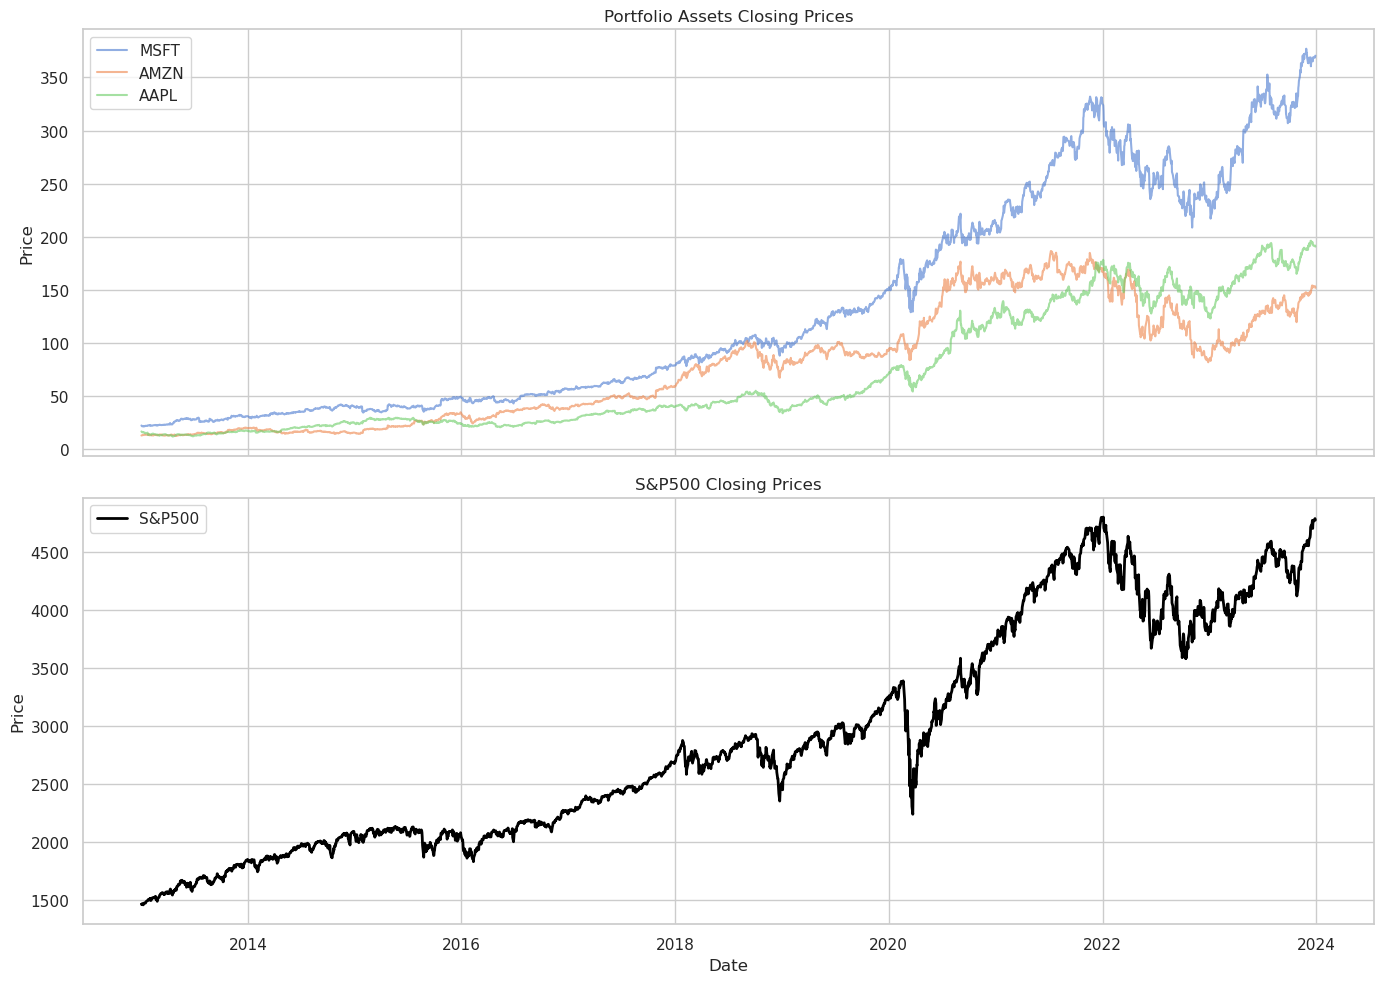

In [3]:
portfolio_prices = pd.concat([df["Close"] for df in df_assets.values()], axis=1)
portfolio_prices.columns = df_assets.keys()
portfolio_prices = portfolio_prices.dropna()

sp500_prices = sp500['Close']

# Plot raw prices
fig, axes = plt.subplots(2, 1, figsize=(14,10), sharex=True)

# Subplot 1: Portfolio assets
for col in portfolio_prices.columns:
    axes[0].plot(portfolio_prices[col], alpha=0.6, label=col)
axes[0].set_title("Portfolio Assets Closing Prices")
axes[0].set_ylabel("Price")
axes[0].legend()

# Subplot 2: S&P500
axes[1].plot(sp500_prices, color="black", label="S&P500", linewidth=2)
axes[1].set_title("S&P500 Closing Prices")
axes[1].set_xlabel("Date")
axes[1].set_ylabel("Price")
axes[1].legend()

plt.tight_layout()
plt.show()


###  Figure 1 — Portfolio Assets Closing Prices

This figure shows the daily closing prices of the assets included in the portfolio (MSFT, AMZN, AAPL) over the study period.

It highlights:

- long-term upward trends  
- differences in price levels between assets  
- higher volatility for some stocks (especially MSFT)

Because the prices grow at different scales, this motivates using **returns instead of raw prices** in the later steps of the project.

###  Figure 2 — S&P 500 Closing Prices

This figure shows the daily closing prices of the S&P 500 index across the study period.  
The index is used as a benchmark to evaluate whether the portfolio outperforms or underperforms the broader market.  

Major market events (e.g., 2020 crash) are clearly visible and help interpret later model results.

## Normalize Prices
Normalize prices to compare relative evolution.

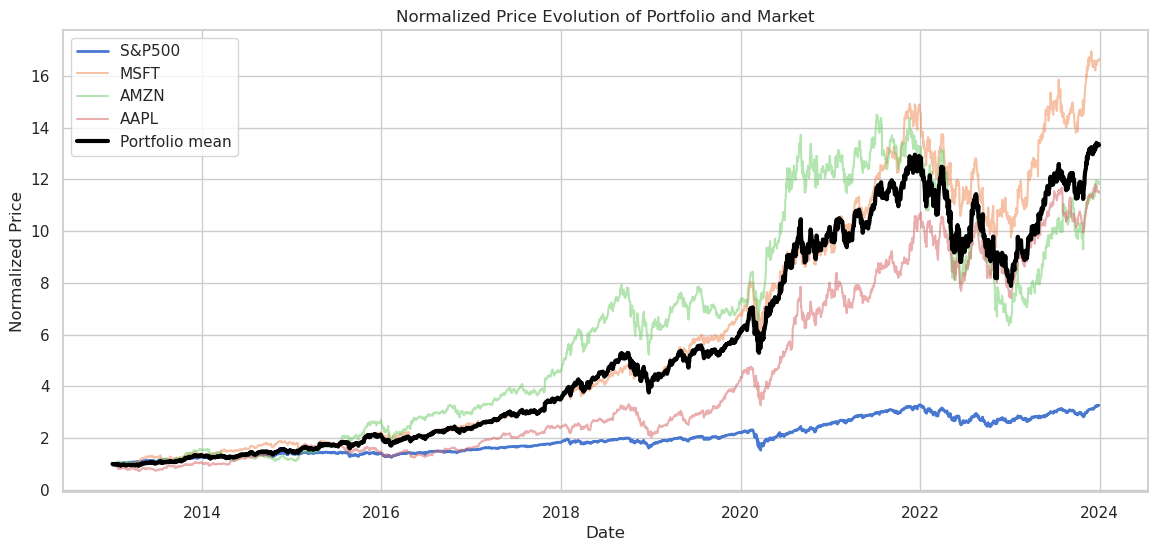

In [4]:
portfolio_norm = portfolio_prices / portfolio_prices.iloc[0]
portfolio_norm['mean'] = portfolio_norm.mean(axis=1)
sp500_norm = sp500_prices / sp500_prices.iloc[0]

plt.figure(figsize=(14,6))
plt.plot(sp500_norm, label="S&P500", linewidth=2)
for col in portfolio_norm.columns[:-1]:
    plt.plot(portfolio_norm[col], alpha=0.5, label=col)
plt.plot(portfolio_norm['mean'], label="Portfolio mean", linewidth=3, color="black")
plt.title("Normalized Price Evolution of Portfolio and Market")
plt.xlabel("Date")
plt.ylabel("Normalized Price")
plt.legend()
plt.show()

###  Figure 3 — Normalized Price Evolution of Portfolio and Market


This figure shows the normalized price evolution of the portfolio assets (MSFT, AMZN, AAPL), their equally-weighted portfolio mean, and the S&P 500 benchmark.

All prices are normalized to 1 at the beginning of the sample so that assets can be compared on the same scale.  
This allows us to focus on relative growth rather than absolute price levels, and clearly shows periods where the portfolio outperforms or underperforms the market.

## Rolling 20-Day Coefficient of Variation (CV)
CV measures relative volatility over a rolling window. 

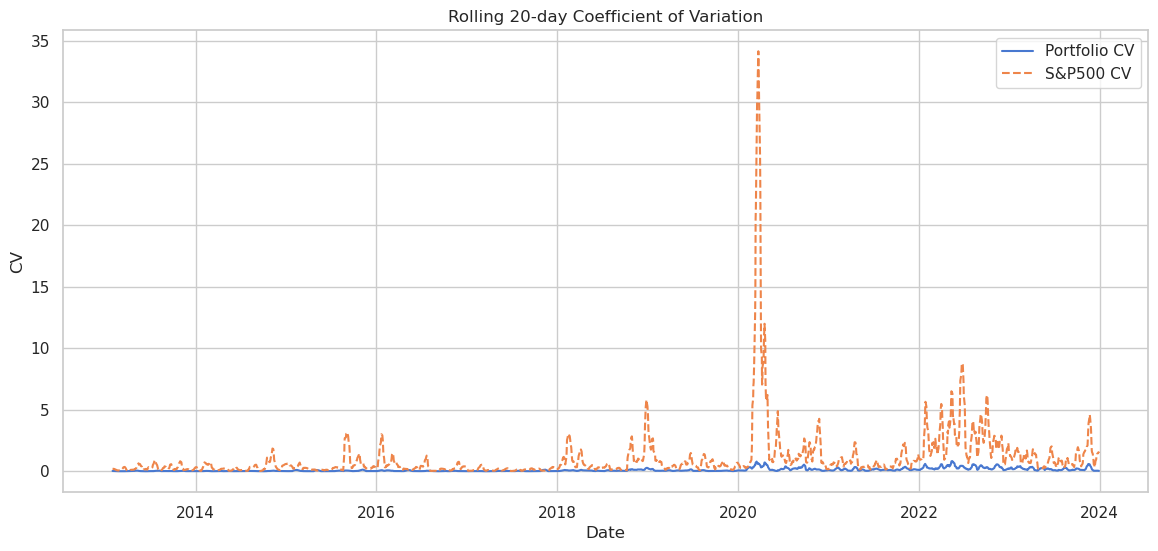

In [5]:
port_rolling_var = portfolio_prices.rolling(window).var().mean(axis=1)
port_rolling_mean = portfolio_prices.rolling(window).mean().mean(axis=1)
cv_rolling_port = port_rolling_var / port_rolling_mean

sp_rolling_var = sp500_prices.rolling(window).var()
sp_rolling_mean = sp500_prices.rolling(window).mean()
cv_rolling_sp = sp_rolling_var / sp_rolling_mean

plt.figure(figsize=(14,6))
plt.plot(cv_rolling_port, label="Portfolio CV")
plt.plot(cv_rolling_sp, label="S&P500 CV", linestyle="--")
plt.title(f"Rolling {window}-day Coefficient of Variation")
plt.xlabel("Date")
plt.ylabel("CV")
plt.legend()
plt.show()


###  Figure 4 — Rolling Coefficient of Variation (Portfolio vs Market)


This figure shows the rolling 20-day coefficient of variation (CV) for both the portfolio and the S&P 500 index.  
The CV is defined as the ratio of rolling volatility to rolling mean returns and provides a scale-free measure of
relative risk. It allows comparison of variability across assets and market conditions over time.



## Rolling Returns
Calculate returns over a rolling window


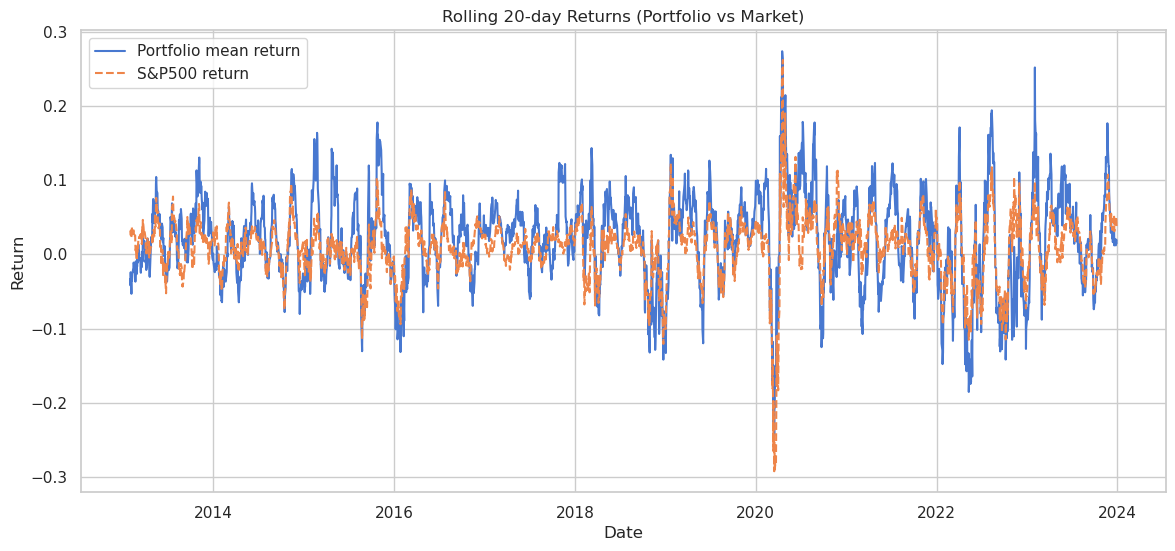

In [6]:
def block_return(block):
    return (block.iloc[-1] - block.iloc[0]) / block.iloc[0]

r_port = portfolio_prices.rolling(window).apply(block_return)
r_port_mean = r_port.mean(axis=1)
r_sp500 = sp500_prices.rolling(window).apply(block_return)

plt.figure(figsize=(14,6))
plt.plot(r_port_mean, label="Portfolio mean return")
plt.plot(r_sp500, label="S&P500 return", linestyle="--")
plt.title(f"Rolling {window}-day Returns (Portfolio vs Market)")
plt.xlabel("Date")
plt.ylabel("Return")
plt.legend()
plt.show()

###  Figure 5 — Rolling 20-day Returns (Portfolio vs Market)


This figure presents the rolling 20-day returns of the equally weighted portfolio and the S&P 500 index.  
Rolling returns smooth short-term fluctuations and highlight medium-term performance trends.

They allow comparison of how the portfolio performs relative to the market benchmark over time.



## Rolling Sharpe Ratio
Sharpe ratio = return adjusted for risk

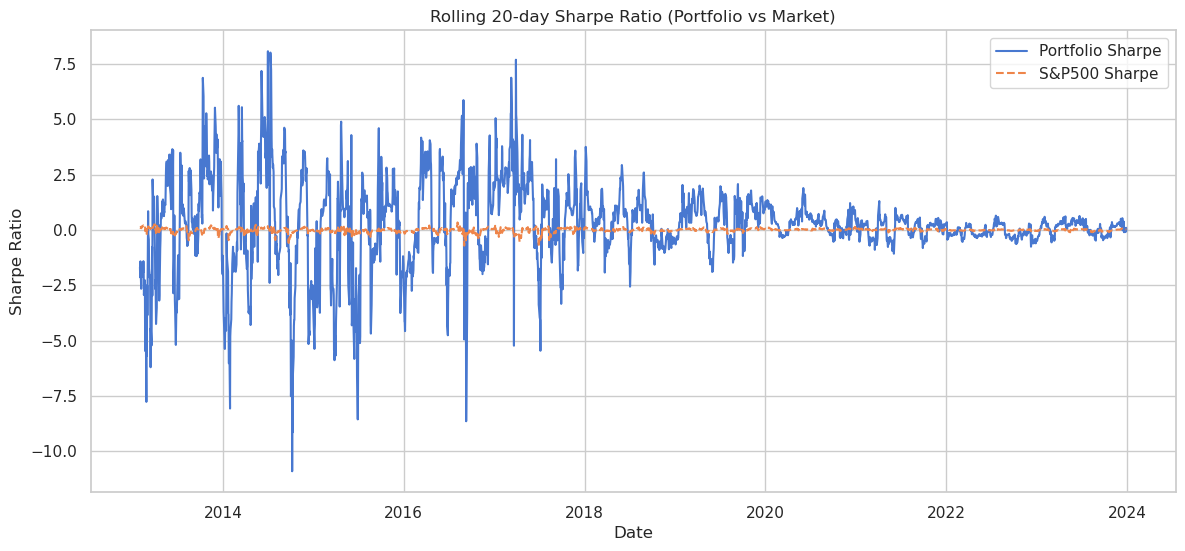

In [7]:
sharpe_port = (r_port_mean - rf['^TNX'].reindex(r_port_mean.index)) / cv_rolling_port
sharpe_sp500 = (r_sp500 - rf['^TNX'].reindex(r_sp500.index)) / cv_rolling_sp

plt.figure(figsize=(14,6))
plt.plot(sharpe_port, label="Portfolio Sharpe")
plt.plot(sharpe_sp500, label="S&P500 Sharpe", linestyle="--")
plt.title(f"Rolling {window}-day Sharpe Ratio (Portfolio vs Market)")
plt.xlabel("Date")
plt.ylabel("Sharpe Ratio")
plt.legend()
plt.show()

###  Figure 6 — Rolling 20-day Sharpe Ratio (Portfolio vs Market)


This figure displays the rolling 20-day Sharpe ratio of the equally weighted portfolio and the S&P 500 index.

The Sharpe ratio measures risk-adjusted performance by comparing excess returns to variability.  
Higher values indicate periods where the portfolio earns more return per unit of risk relative to the market benchmark.

*(Update “20-day” only if the rolling window changes.)*

## Rolling Covariance
Rolling covariance between portfolio and benchmark

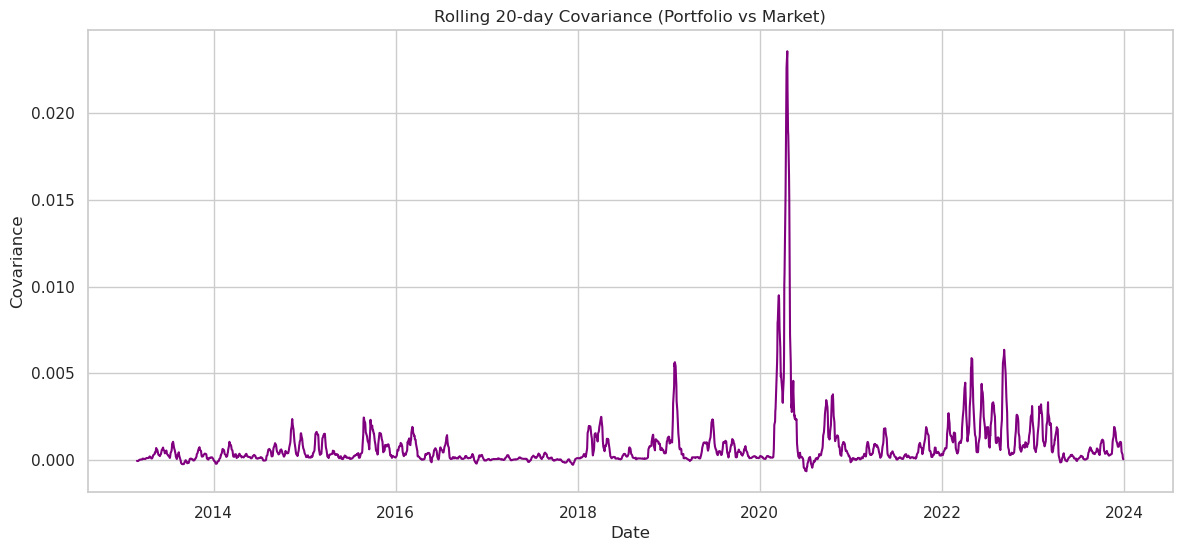

In [8]:
df_rend = pd.concat([r_port_mean, r_sp500], axis=1)
df_rend.columns = ['portfolio', 'sp500']

cov_by_block = df_rend['portfolio'].rolling(window).cov(df_rend['sp500'])

plt.figure(figsize=(14,6))
plt.plot(cov_by_block, color="purple")
plt.title(f"Rolling {window}-day Covariance (Portfolio vs Market)")
plt.xlabel("Date")
plt.ylabel("Covariance")
plt.show()

###  Figure 7 — Rolling 20-day Covariance (Portfolio vs Market)


This figure shows the rolling 20-day covariance between the portfolio’s returns and the S&P 500.  
Covariance indicates how strongly the portfolio and the market move together over time.  
Higher spikes suggest periods where the portfolio became more sensitive to overall market movements.

## Binary Indicator: Portfolio Outperforms S&P500

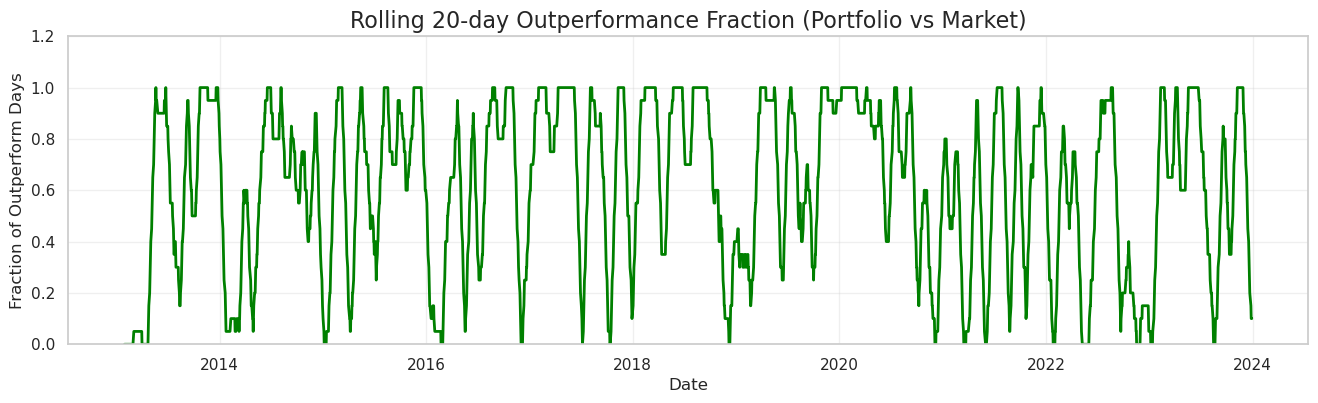

Percentage of days portfolio > S&P500: 61.13%


In [9]:
r_port_21 = portfolio_prices.rolling(window+1).apply(block_return)
r_port_mean_21 = r_port.mean(axis=1)
r_sp500_21 = sp500_prices.rolling(window+1).apply(block_return)
result = (r_port_mean_21 > r_sp500_21).astype(int)

rolling_result = result.rolling(window=20).mean()  # 20-day rolling fraction

plt.figure(figsize=(16,4))
plt.plot(rolling_result, color='green', linewidth=2)
plt.title("Rolling 20-day Outperformance Fraction (Portfolio vs Market)", fontsize=16)
plt.xlabel("Date")
plt.ylabel("Fraction of Outperform Days")
plt.ylim(0,1.2)
plt.grid(alpha=0.3)
plt.show()


print(f"Percentage of days portfolio > S&P500: {result.mean()*100:.2f}%")

###  Figure 8 — Rolling 20-day Outperformance Fraction (Portfolio vs Market)


This figure shows the rolling 20-day fraction of days where the portfolio’s return exceeds the S&P 500 return.  
Each day is encoded as either outperformance (1) or underperformance (0), and the rolling average represents
the proportion of outperformance within each window.  

This metric provides an intuitive, probabilistic view of how frequently the portfolio beats the market over time.

## Distribution of Rolling Sharpe Ratios

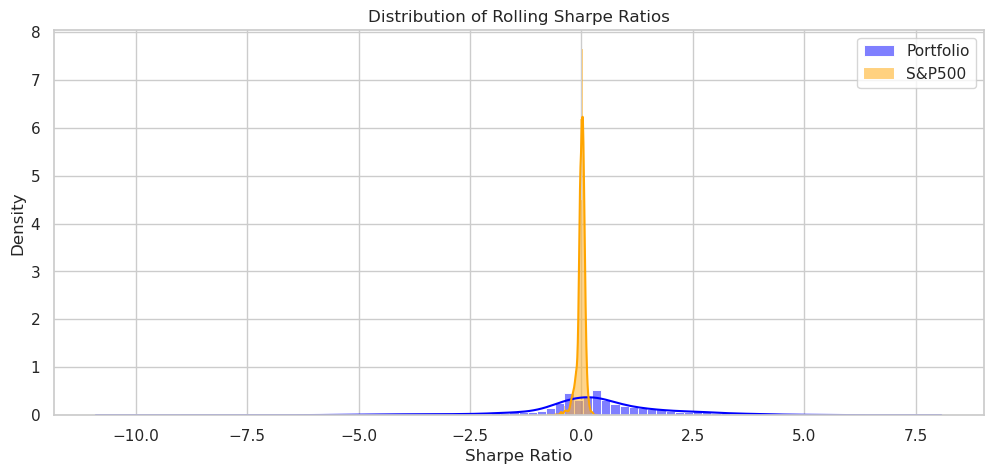

In [10]:
plt.figure(figsize=(12,5))
sns.histplot(sharpe_port, color="blue", label="Portfolio", kde=True, stat="density")
sns.histplot(sharpe_sp500, color="orange", label="S&P500", kde=True, stat="density")
plt.title("Distribution of Rolling Sharpe Ratios")
plt.xlabel("Sharpe Ratio")
plt.ylabel("Density")
plt.legend()
plt.show()


###  Figure 9 — Distribution of Rolling Sharpe Ratios


This figure compares the empirical distributions of rolling Sharpe ratios for the portfolio and the S&P 500 index.  

The distributions highlight differences in dispersion, skewness, and tail behavior, showing how risk-adjusted returns vary over time between the portfolio and the market benchmark.